In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from keras import models
from keras import layers
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

random.seed(10)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bank.csv to bank.csv


In [3]:
import io
dataframe = pd.read_csv(io.BytesIO(uploaded['bank.csv']),  sep=";")

In [4]:
dataframe = dataframe.drop("duration", axis=1)
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [5]:
dataframe["y"].replace(["yes","no"],[1,0], inplace=True)
dataframe.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [6]:
dummies = pd.get_dummies(dataframe[['job','marital', 'education','default','housing','loan','contact','month','poutcome']])

# Drop columns for which we created dummy variables
X_ = dataframe.drop(['job', 'marital', 'education','default','housing','loan','contact','month','poutcome'], axis=1).astype('float64')

# Define the feature set X.
dataframe_new = pd.concat([dummies,X_], axis=1)
dataframe_new.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,y
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,58.0,2143.0,5.0,1.0,-1.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,44.0,29.0,5.0,1.0,-1.0,0.0,0.0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,33.0,2.0,5.0,1.0,-1.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,47.0,1506.0,5.0,1.0,-1.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,33.0,1.0,5.0,1.0,-1.0,0.0,0.0


In [7]:
X = dataframe_new.drop(['y'],axis=1) #see note below
y = dataframe_new['y']
print(X.shape)
print(y.shape)

(45211, 50)
(45211,)


In [8]:
#split train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =.8, test_size=.2,
                                                    random_state=42, stratify=y)

#we stratified data by output feature variable 'y' to ensure even spread of data in both data sets

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [10]:
X_train.shape

(36168, 50)

In [11]:
X_test.shape

(9043, 50)

In [12]:
#Let's see how well the neural network performs this classification task
#we will start with a basic 3 layer neural network with 16 neurons
nw = models.Sequential()

#add layers to model
nw.add(layers.Dense(16, activation='relu', input_shape=(50,)))
nw.add(layers.Dense(1, activation='sigmoid'))
nw.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [13]:
#roc auc score
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# compile model using adam for the optimizer and binary_crossentropy as the loss function
nw.compile(optimizer='adam',
          loss='binary_crossentropy',#using binary cross entropy since y is binary
         metrics=['accuracy', auroc])


In [14]:
#lets fit the data to the neural net run 10 epochs, 512 batch size, 
nw.fit(X_train, y_train, epochs=10,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/10
71/71 [==============================] - 3s 10ms/step - loss: 0.5182 - accuracy: 0.7832 - auroc: 0.6346 - val_loss: 0.3576 - val_accuracy: 0.8817 - val_auroc: 0.6929
Epoch 2/10
71/71 [==============================] - 0s 6ms/step - loss: 0.3429 - accuracy: 0.8849 - auroc: 0.7022 - val_loss: 0.3188 - val_accuracy: 0.8907 - val_auroc: 0.7327
Epoch 3/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3170 - accuracy: 0.8905 - auroc: 0.7300 - val_loss: 0.3092 - val_accuracy: 0.8919 - val_auroc: 0.7508
Epoch 4/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3022 - accuracy: 0.8936 - auroc: 0.7605 - val_loss: 0.3053 - val_accuracy: 0.8931 - val_auroc: 0.7581
Epoch 5/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3055 - accuracy: 0.8918 - auroc: 0.7600 - val_loss: 0.3030 - val_accuracy: 0.8935 - val_auroc: 0.7631
Epoch 6/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2987 - accuracy: 0.8933 - auroc: 0.7668 - val

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


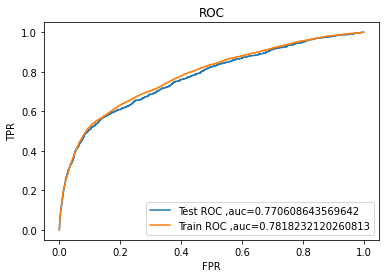

AUC on Test data is 0.770608643569642
AUC on Train data is 0.7818232120260813
---------------------------


In [15]:
pred_test =nw.predict_proba(X_test)[:,0]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = nw.predict_proba(X_train)
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred_train)

#ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test, pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test, pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

In [16]:
#lets try to increase layers to 4
nw = models.Sequential()

#add layers to model
nw.add(layers.Dense(16, activation='relu', input_shape=(50,)))
nw.add(layers.Dense(16, activation='relu'))
nw.add(layers.Dense(1, activation='sigmoid'))

In [17]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

#compile model using adam for the optimizer and binary_crossentropy as the loss function
nw.compile(optimizer='adam',
          loss='binary_crossentropy',#using binary cross entropy since y is binary
          metrics=['accuracy', auroc])

In [18]:
nw.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
71/71 [==============================] - 1s 7ms/step - loss: 0.6889 - accuracy: 0.6009 - auroc: 0.4855 - val_loss: 0.3707 - val_accuracy: 0.8779 - val_auroc: 0.6230
Epoch 2/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3587 - accuracy: 0.8782 - auroc: 0.6571 - val_loss: 0.3246 - val_accuracy: 0.8841 - val_auroc: 0.7221
Epoch 3/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3197 - accuracy: 0.8865 - auroc: 0.7265 - val_loss: 0.3130 - val_accuracy: 0.8891 - val_auroc: 0.7463
Epoch 4/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3076 - accuracy: 0.8898 - auroc: 0.7536 - val_loss: 0.3075 - val_accuracy: 0.8911 - val_auroc: 0.7569
Epoch 5/10
71/71 [==============================] - 0s 5ms/step - loss: 0.3079 - accuracy: 0.8902 - auroc: 0.7553 - val_loss: 0.3044 - val_accuracy: 0.8919 - val_auroc: 0.7620
Epoch 6/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2971 - accuracy: 0.8930 - auroc: 0.7715 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


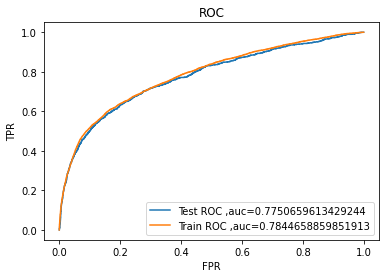

AUC on Test data is 0.7750659613429244
AUC on Train data is 0.7844658859851913
---------------------------


In [19]:
pred_test =nw.predict_proba(X_test)[:,0]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = nw.predict_proba(X_train)
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred_train)

#ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test, pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test, pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

In [20]:
#lets try to increase neurons to 128
nw = models.Sequential()

#add layers to model
nw.add(layers.Dense(128, activation='relu', input_shape=(50,)))
nw.add(layers.Dense(128, activation='relu'))
nw.add(layers.Dense(1, activation='sigmoid'))


In [21]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

#compile model using adam for the optimizer and binary_crossentropy as the loss function
nw.compile(optimizer='adam',
          loss='binary_crossentropy',#using binary cross entropy since y is binary
          metrics=['accuracy', auroc])

In [22]:
nw.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
71/71 [==============================] - 1s 7ms/step - loss: 0.3900 - accuracy: 0.8663 - auroc: 0.5821 - val_loss: 0.2958 - val_accuracy: 0.8937 - val_auroc: 0.7808
Epoch 2/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2865 - accuracy: 0.8970 - auroc: 0.7880 - val_loss: 0.2932 - val_accuracy: 0.8951 - val_auroc: 0.7870
Epoch 3/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2852 - accuracy: 0.8971 - auroc: 0.7939 - val_loss: 0.2916 - val_accuracy: 0.8945 - val_auroc: 0.7875
Epoch 4/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2933 - accuracy: 0.8916 - auroc: 0.7949 - val_loss: 0.2911 - val_accuracy: 0.8948 - val_auroc: 0.7841
Epoch 5/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2915 - accuracy: 0.8927 - auroc: 0.8039 - val_loss: 0.2897 - val_accuracy: 0.8952 - val_auroc: 0.7905
Epoch 6/10
71/71 [==============================] - 0s 5ms/step - loss: 0.2803 - accuracy: 0.8963 - auroc: 0.8145 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


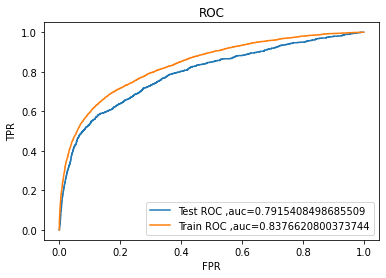

AUC on Test data is 0.7915408498685509
AUC on Train data is 0.8376620800373744
---------------------------


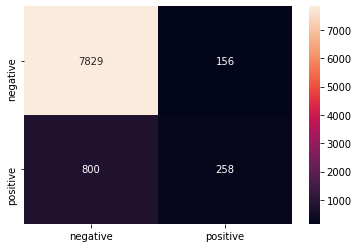

In [23]:


pred_test = nw.predict_proba(X_test)[:,0]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = nw.predict_proba(X_train)
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred_train)

#ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test, pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test, pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [24]:
results=pd.DataFrame(columns=['Model', 'Number of Hidden layers' ,"Number of Neurons", 'Train-AUC', 'Test-AUC' ])

In [25]:
results.loc[0] = ['3-layers','1 Hidden Layers ',"16 Neurons",0.7769,0.7817]
results.loc[1] = ['4-layers','2 Hidden Layers',"16 Neurons",0.7886,0.7842]
results.loc[2] = ['4-layers','2 Hidden Layers',"128 Neurons",0.8392, 0.7896]
results

,Model,Number of Hidden layers,Number of Neurons,Train-AUC,Test-AUC
0,3-layers,1 Hidden Layers,16 Neurons,0.7769,0.7817
1,4-layers,2 Hidden Layers,16 Neurons,0.7886,0.7842
2,4-layers,2 Hidden Layers,128 Neurons,0.8392,0.7896
